# Llama3-8BによるLivedoor-newsの9ジャンル判別タスク解法 (Japanese Livedoor News 9-Genre Classification Task Solution Using Llama3-8B)

## 1. ライブラリをインポート (Import library)

GPUを確認 (Confirm GPU)

In [ ]:
!nvidia-smi

Sun May 19 08:15:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   41C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [ ]:
# Install Pytorch
%pip install "torch==2.2.2" tensorboard

# Install Hugging Face libraries
%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import time
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate
import matplotlib.pylab as plt

from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


## 2. livedoor-news-dataをインポート (import livedoor-news-data)


In [ ]:
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar -zxvf ldcc-20140209.tar.gz

In [ ]:
from pathlib import Path
datapath = Path('text/')
topics = [x.parts[-1] for x in datapath.iterdir() if x.is_dir()]
topics

['kaden-channel',
 'livedoor-homme',
 'topic-news',
 'sports-watch',
 'peachy',
 'dokujo-tsushin',
 'it-life-hack',
 'movie-enter',
 'smax']

In [ ]:
from sklearn.datasets import load_files
dataset = load_files(datapath, encoding='utf8')
dataset.data = [doc.split('\n', 2)[2] for doc in dataset.data]
dataset.data[0]

'NY名物イベントが日本でも！名店グルメを気軽に楽しむ\nニューヨークで20年続いている食の祭典「レストラン・ウィーク」。その日本版がダイナーズクラブ特別協賛のもと7月30日よりスタート。8月31日までの期間中、青山・六本木、丸の内、銀座、横浜のエリアから、ラグジュアリーレストラン81店舗がこのイベントのために特別用意したランチメニュー2010円（税・サ別）、ディナー5000円（税・サ別）を気軽に楽しめる、とっておきのイベントです。\n\u3000\n\u3000実行委員長には、学校法人服部学園、服部栄養専門学校 理事長・校長であり医学博士でもある服部幸應氏を迎え、実行委員に石田純一さん、LA BETTOLAオーナーシェフ落合務氏、フードアナリスト協会会長、高賀右近氏、つきぢ田村三代目、田村隆氏に、そして放送作家・脚本家の小山薫堂さんなど、食のスペシャリストたちが勢揃い。\n\n参加レストランには、ミシュランのフランス版、東京版ともに星を獲得している吉野建シェフの「レストラン タテル ヨシノ 汐留」や、日本料理の名門「つきぢ田村」、「金田中 庵」、「赤坂璃宮」に「mikuni MARUNOUCHI」など、日本を代表するレストランがずらり。\n\u3000イベント期間の〜8月19日までは、特別協賛のダイナーズクラブカード会員、またはシティバンクに口座を持つシティゴールドメンバーが楽しめる先行期間となりますが、その後は誰でも参加できるので、日程のチェックは必須。\n\n\u3000予約方法は必ず事前に、各店舗に問合せを行い「ジャパンレストラン・ウィーク2010」での予約であることを伝えればOK！憧れていたレストランの料理をリーズナブルにいただけるチャンスです！極上の味とラグジュアリーな空間を満喫。そんな幸せを実感できる「ジャパンレストラン・ウィーク2010」にぜひ参加しててみてはいかがですか？\n\nJAPAN RESTAURANT WEEK 2010 -公式サイト\n'

In [ ]:
dataset.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [ ]:
len(dataset.data)

7376

In [ ]:
len(dataset.filenames)

7376

In [ ]:
dataset.filenames[0].split('/')[1]

'peachy'

In [ ]:
X = pd.DataFrame(dataset.data, columns=['input'])
X[0:1]

,input
0,NY名物イベントが日本でも！名店グルメを気軽に楽しむ\nニューヨークで20年続いている食の祭...


In [ ]:
y = pd.DataFrame(dataset.filenames, columns=['output2'])
y[0:3]

,output2
0,text/peachy/peachy-4931238.txt
1,text/topic-news/topic-news-6655079.txt
2,text/sports-watch/sports-watch-5172424.txt


In [ ]:
y['output']=y['output2'].apply(lambda x: x.split('/')[1])
y=y[['output']]
y[0:3]

,output
0,peachy
1,topic-news
2,sports-watch


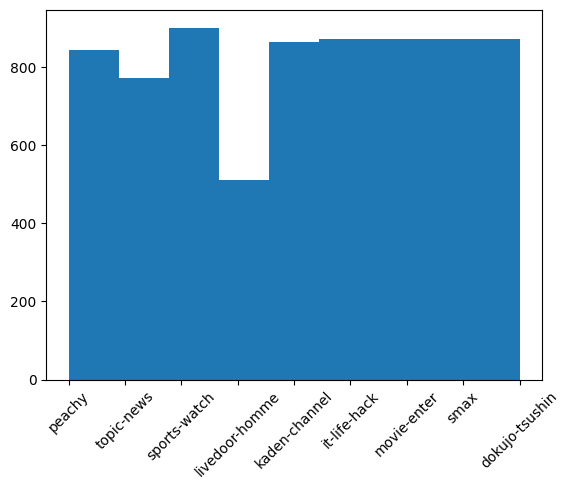

In [ ]:
plt.hist(y,bins=9)
plt.xticks(rotation=45)
plt.show()

In [ ]:
X.size, y.size

(7376, 7376)

## 3. 訓練データと検証データを作成　(Prepare training and valid data)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.7, test_size=0.3, random_state=200)
len(X_train), len(y_train), len(X_valid), len(y_valid)

(5163, 5163, 2213, 2213)

In [ ]:
pd.set_option("display.max_colwidth", 5000)

In [ ]:
y_train.nunique()

output    9
dtype: int64

In [ ]:
y_valid.nunique()

output    9
dtype: int64

## 4. Alpacaスタイルのデータセット作成 (Cretate Alpaca style data set)

In [ ]:
data_train = pd.concat([y_train, X_train], axis=1)
data_train["instruction"]= "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'"
data_train = data_train.reindex(columns=['instruction','input','output'])
data_train[0:3]

,instruction,input,output
4365,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'",イマドキOLのホンネ座談会「スマートなオトコの新基準とは？」\n先日発表になった『2011年の冬のボーナスの見通し』によれば、民間企業の一人当たりの平均支給額は37万2500円（前年比-1.8％）と3年連続で減少。支給月で計算すると1.52ヶ月（前年比-0.03ヶ月）と、これは比較可能な1990年からの数字で過去最低を更新しただけでなく、08年に発生したリーマンショックによって激減したボーナスをさらに下回る額となった。\nそんなサラリーマンの寒い懐事情を知ってか知らずか、OLたちのオトコを見る目はさらにシビアになってきている。そこで今回はイマドキOL座談会を開催して「スマートな男性像」を聞いてみることにした。仕事、日常生活、デートの支払いに至るまで、OLが語る新基準のオトコ選びのホンネとは？ \n\n■出席者4名\nまりこ（26歳/大手損害保険会社勤務）\nはるな（25歳/大手損害保険会社勤務）\nなつみ（29歳/某メーカー勤務）\nあい（28歳/アパレル勤務）\n\n\n——今回は「男性のスマートさ」というテーマで、みなさんにお話を伺っていきたいのですが、まずは日常生活において、男性のどんなところにスマートさを感じますか？\n\nまりこ：私は、スマートフォンやiPadなどの最新のデジタルツールを使いこなしたり、情報をしっかりキャッチしている人はスマートに見えますよね。「iPadとかよくわからないんだよね……」とか言われると、もうちょっとアンテナ張ってよ！って思ったりします（笑） もちろん1から10まで全部を知っていて欲しいということではなくて、せめて世間的に話題になっていることは押さえておいてほしいですよね。\n\nはるな：ニュースや流行のポイントを抑えている人ってスマートですよね。AKB48にしても「全然知らない」と言われるよりは、逆にものすごい詳しいほうが面白い人だなって思いますもん。話のネタにもなりますしね。\n\nなつみ：オフィスでスマートだなと思うのは、忙しい時にも冗談を言ったりできて、忙しいオーラを出さない人ってスマートですよね。逆に空気を読んで話しかけないといけない人や、無愛想な人は「余裕がないのかな」と思ってしまいます。\n\nあい：それわかる！ 話しかけやすいオーラがある人っていいですよね。余裕を感じるというか。逆にクールに装っている人や、そっけない態度の人なんて全然スマートではないし、魅力を感じないですから（笑）\n\nまりこ：あと、オフィスで感じるのは、タンブラーでお茶を飲んでいる人って素敵に見えますね。無駄遣いしない、経済観念がしっかりしている人だろうなという印象を持ちます。毎日ペットボトルのお茶や缶コーヒーばかり飲んでいたり、机の上に空き缶が並んでいるのもだらしないですからね。\n\n——毎日ランニングしたり、仕事の後にスポーツするなど、忙しい中でも運動を欠かさず、体重や体調管理をしている人って、スマートさを感じますか？\n\nはるな：過去に「肥満・喫煙者＝自己管理のできない人」という記事を読んだことがあって、それ以来、体調管理できる人は素敵だなと思うようになりました。\n\nなつみ：でも「毎日トレーニングやってるぜ」って自慢する人には、「仕事ないのかよ」って突っ込みたくなります（笑） 適度に自己管理できてる人は素敵ですよね。自宅でストレッチしてますとか、腕立てしますって聞くほうが、ジムでお金使ってますって人よりもスマートに見えてしまいますよね。\n\nまりこ：今って、どんどん給与水準が下がってきていて、結婚して子供もいたりすれば、旦那さんのお小遣いって減っていくわけじゃないですか。女性ってそのあたりをしっかりわかっているので、とてもシビアに見ていますから、お金を掛けないでやりくりする人はスマートに映りますよね。\n\nあい：でもケチはイヤ！女性のケチってプラスに見えますけど、男性のケチって最悪ですよねｗ女性は自己満足。無駄なことが嫌いで、節約にもストイックですよね。楽しんでやっちゃう、節約することに価値を見出せるんです。でも男性って節約して、その先に対価を求める。そこが大きな違いです。\n\n——お金の話が出ましたが、男性の財布の中身って気になりますか？\n\nまりこ：ふとしたタイミングで見てしまいますよね（笑） やっぱりボロボロで汚れた財布は気になります。お財布って性格が出ますよね。キレイだときちんとお金を管理してそうだなと思うし、レシートだらけで整理されてないとお金にもだらしない気がします（笑）\n\nなつみ：あと、ポイントカードだらけとかもイヤかも（笑）\n\n全員：わかるー！！\n\nはるな：あと、クレジットカードの類はチラっと見ますね。その人に対しての社会的信用って、なんとなく気になりますから。\n\n——支払いでカードを使って済ませる男性も多いと思いますが、ポイントを貯めたり堅実に使っている人はどう思いますか？\n\nあい：クーポンを使ってもらうのは構わないですけど、お会計のときにケータイでクーポン探したり、レシートを細かくチェックするような行動はちょっとイヤですね。一緒にいてこっちが恥ずかしくなる。カードでスムーズに済ませてくれる形がスマートですよね。\n\nはるな：もちろんクーポンだって悪くはないんですよ！ 初めてのデートだったり、付き合ったばかりのときはご馳走して欲しいんですけど、しばらく経ってきたらクーポンを使ったり、カードもポイントを貯めて賢く使って欲しいです。クレジットカードってポイントでできることがかなりあるじゃないですか。そういうことを知っている人って、経済観念のしっかりした人だなって思いますよ。\n\nなつみ：そうだね。一緒に過ごすことが日常になりはじめたら、経済観念をしっかりしてほしいですね。でも誕生日とかにクーポンとかイヤかも（笑）\n\nまりこ：お金を場面に合わせて使える人はスマートだということですね。お金のTPOがわかる人は、きっとライフプランもしっかりしているはずですから。もちろん、素敵なお店を知っているに越したことはないですけどね。\n\nあい：お金も生活もメリハリがしっかりしている人がスマートということだと思います。\n\n■イマドキOLのホンネは【こちら】から\n■アメリカン・エキスプレス・カード\n,livedoor-homme
3389,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'","ライカからオールインワンタイプの光学24倍のズームレンズデジカメ「V-LUX3」発売【売れ筋チェック】\n今年の終盤は値段の下がった旧モデルに人気が集まり、すっかり守りに入った感のあるデジタル一眼レフカメラ市場。年明けとともに新製品ラッシュの予感がする中、老舗メーカーから新製品の登場だ。\n\nライカカメラは、24倍ズームレンズ搭載のデジタルカメラ「ライカ V-LUX3」を2012年1月に発売する。\n■光学24倍のズームレンズがスゴイ\n本製品最大の特長は、光学24倍のズームレンズ。焦点距離範囲が非常に広く、広角25mmから超望遠600mmまで対応するライカ バリオ・エルマリートf2.8-5.2/4.5-108mm ASPH.を搭載。広大な景色をレンズでとらえられ、遠方まで鮮明に描写できる。また、パワーOISが手ぶれを補正するので、手持ちの撮影もOKだ。 \n\n■優れた描写力と素早いオートフォーカスでどんなシーンにも対応\n新開発のCMOSセンサーで、優れた描写力を実現。あらゆる撮影シーンで、動画も静止画も優れた画質で撮影が可能だ。さらに、本製品は作動速度を最重視。10分の１秒未満で反応するオートフォーカスが素早く動く被写体も確実に捉え、連写速度も秀逸。どんなシーンにも対応できるオールインワンタイプのデジカメと言える。\n\n■スペック\n型番： V-LUX3 \n直営店販売価格：98,700円 \n外形寸法： 124×95×81mm(幅×奥行×高さ)\n重量： 540g(バッテリ/メモリーカード含む)\n\nライカ ホームページ\n \n\n■関連記事\nデジタル一眼レフカメラは現在コスパ重視の傾向、来年は新製品ラッシュの予感！\n\n \n（牧田 亜紀子）\n \n\n■関連記事\n・スタジアムにいなくても一緒に応援！ バルセロナVSアルサッド戦で「VAMOS VIEWING」初体験【レポート】\n・今年一番秋葉でがんばったのはだれ？ PC萌えキャラ人気コンテスト投票開始【話題】\n・今年のベストセラーはやっぱりジョブズの伝記！ でも日本人ってこんなにジョブズ好きだったっけ？【話題

In [ ]:
data_valid = pd.concat([y_valid, X_valid], axis=1)
data_valid["instruction"]= "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'"
data_valid=data_valid.reindex(columns=['instruction','input','output'])
data_valid[0:3]

,instruction,input,output
4441,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'","独女的映画レビュー vol.3 『カンバセーションズ』\n“男はズルいロマンチスト、女は罪なリアリスト”\n\nなんて巧いこと言うのでしょう。男と女の性質を一言で表現するのなら、これ以上の言葉はないのでは？\n\n第18回東京国際映画祭コンペティション部門にて「女たちとの会話」の題で上映され、審査員特別賞と最優秀主演女優賞（ヘレナ・ボトム＝カーター）を受賞した『カンバセーションズ』。\n\n10年前に離婚した、元夫の妹の結婚式に、女はなぜ現れたのか？\n“好奇心”？“来るべきじゃなかった”と知るために？\nそれとも“マイレージでタダ旅行”をしたかっただけなのか？ \nその答えは、ラストカットできっと分かります。\n\n19歳の時に出会った元夫は、情熱的で、ロマンチックで、少年のように無邪気で、彼女にとって青春そのもの。毎日が楽しくて、刺激的で、セックスに明け暮れたあの頃…。幸せだった。けれども惨めだった。愛せば愛すほど傷つき、彼女は疲れてしまった。そして姿を消した。\n\n男は女を失って初めて気付く。自分がどれだけ彼女を傷つけていたのか、彼女がどれだけ大切だったのか。追われると逃げたくなるのに、逃げられると追いたくなる。彼女が消えて10年という時が経っても、男は女を忘れられずにいた。\n\n子供の頃の“初恋の相手”以上に、“初めて愛を知った相手”は、誰にとっても特別なはず。少なくとも女にとっては。19歳から38歳になった女は、同じ男を前にどのように感じるのか？少女の頃の淡い気持ちを思い出しながらも、大人の女になった彼女の、現実的な発言、行動、全てが、あまりにも赤裸々で、共感せずにはいられないでしょう。\n\nそして、最も印象に残っているのは、このセリフ。\n\n「あなたとは全く同じ年なのに、あなたは少年で、私だけが遥かに年を取っているように感じるわ」\n\nこの感覚、女性なら、誰もが感じたことがあるのでは？“子供のように自由で、無邪気で、一緒にいてドキドキ出来る”、そういう男に、女は弱い。彼女もそんな彼に惹かれ、今でももちろんロマンチックな気持ちを持っている。けれど、女が男に求めるものは、年と共に変わっていくのかもしれない。\n追い求める“恋”でなく、居場所を与えてくれる“愛”へと……。\n\nラストシーンで、タクシー運転手のある問いに答える彼女のセリフ「No, no more」。この一言が、切ない…！！女は男よりずっと強い。女には現実と未来しかないのだ。生まれ変わっても、“罪なリアリスト”である、女に生まれたい。そんな風に思わせてくれる、“大人の女”のための一本！物思いに耽りたい一人の夜に、オススメです！！\n",dokujo-tsushin
4532,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'",友達管理が簡単に！ Facebookで新しいリストを作成する【知っ得！虎の巻】\n先週、。友達を［親しい友達］リストに登録して、投稿を絞り込む方法を紹介した。しかし、すべての友達をこのリストに入れてしまったら、絞り込んでもかなりの数の投稿が並んでしまい、あまり意味がなくなってしまうことも。そんな時は、新たに自分でリストを作成しよう。\n\n■新しくリストを作成して、友達をグループ分けする\n一口に「友達」といっても、同級生、仕事つながりの友達、趣味のサークルの友達など、さまざまに分類されるはず。このように友達をグループ分けして、新しく作成したリストにそれぞれ登録しておけば、簡単に投稿を絞り込める。\n\n●リストを作成する\nニュースフィードを表示した状態で、画面左側の［友達］にマウスポインターを合わせると、右側に［もっと見る］が表示されるので、これをクリックする（画面1）。\n\n \n画面1 ［友達］の右側の［もっと見る］をクリックする。 \n\n友達画面が開くので、［リストを作成］をクリックする（画面2）。\n\n \n画面2 ［リストを作成］をクリックする。 \n\n［リスト名］にリストに付ける名前を入力し、［メンバー］に登録したい友達の名前を入力し、友達が表示されたらクリックする（画面3）。\n\n \n画面3 ［リスト名］に名前を入力、［メンバー］に友達を入力していく。 \n\nすべてのメンバーを入力したら、［作成］をクリックすれば登録は完了だ。ニュースフィードの［友達］欄に新しく作成したリスト名が表示される（画面4）。これをクリックすることで、そのリストに登録している友達の投稿だけを絞り込んで表示することができる。\n\n \n画面4 新しく作成したリスト名が表示される。クリックすると投稿が絞り込んで表示される。 \n\nなお、作成済みのリストに新しく友達を追加する方法は、前回紹介した通りだ。\n\n友達の数が多いと、リスト分けするのも一苦労。なるべく早いうちにリストを作成しておき、新しく友達になったらすぐにリストに登録するようにするといいだろう。\n\n編集部：池田利夫＋岡本奈知子（ジャムハウス）\n制作編集：エヌプラス\nCopyright 2012 livedoor. All rights reserved.\n■PC便利技が満載！「知っ得！虎の巻」ブログ\n\n\n\n\n■「知っ得！虎の巻」の記事をもっとみる\n・見積書や企画書を移動中にチェック！ GoogleドライブにAndroidからアクセス\n・計算式をすばやくチェックできるExcelの便利ワザ\n・よく使うファイルを高速に呼び出す タスクバーカスタマイズ術\n・肩や腕の負担を軽減するExcel／Wordキー操作術\n・起動を高速化！ いらないアプリはスタートアップから外す\n,it-life-hack
2839,"You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'","「ハートフル」なクリスマスケーキはいかが？\n 社会全体になんとなく元気のなかった2009年も、あと2ヶ月で終わり。せめて、締めくくりは、大切な人たちと温かくやさしい気持ちで過ごしたい…。\n\n そんなあなたは、希望の象徴である「星」や、きずなのイメージを託した「リボン」をモチーフにしたクリスマスケーキをチェックしてみてはいかが？\n\n 西武池袋本店、今年のクリスマスケーキのテーマは「ハートフル」（＝心のこもった、優しさがあふれた）。聖夜に祈りを託して。2010年は、ハートフルな年になりますように！\n\n★家族や仲間との「ハートフル」な時間を彩るケーキ\n\n☆スーパーパティシエ4人の8アソートケーキ（直径約15?）6,300円[配送料込・冷凍]\n（そごう・西武限定）\n実力派パティシエが自慢のケーキをアソートした贅沢な一品。\nマルメゾン：パンプキンキャラメル、マルメゾン：マロンショコラ、アニバーサリー：ストロベリークリュ、ガトー・ド・ボア：ラマンボ、ル パティシエ タカギ：キャラメルショコラ、アニバーサリー：フロマージュクリュ、ガトー・ド・ボア：ノエル グリオット、ル パティシエ タカギ：フランボワーズピスターシュ\n\n☆パティスリー・サダハル・アオキ・パリ／クレーム フレーズ（直径約18cm）5,670円\n（西武池袋本店限定）\nバニラを贅沢に使用したリッチなシャンティークリーム仕立て、AOKI初のクリスマスショートケーキです。\n\n☆ショコラティエ・パレ・ド・オール／ノエルの贈り物（直径約15cm）4，200円\n（西武池袋本店限定）\nチョコレート生地の間にキャラメルとバニラのムースをサンドし、カカオムースで包み込んだやさしい味わいのチョコレートケーキ。\n\n☆新宿高野／ノエルブラン（直径約19?）10，500円\n（西武池袋本店限定）\nレアチーズと苺のサンドのデコレーションにホワイトチョコのソースをかけ、フルーツをたっぷり飾ったパーティサイズのケーキ。\n\n★大切な人に「ハートフル」な気持ちを伝える特別なケーキ\n\n☆ル パティシエ タカギ／リューバンドーム（直径約15?）6,825円 [配送料込・冷凍]\n（そごう・西武限定）\nホワイトチョコレートのムースにフランボワーズをしのばせ、かわいらしいピンクのショコラをかけました。大切

### train data : 1000 samples,   validation data : 1000 samples

In [ ]:
n=0
m=1000
df_train = data_train.iloc[:m,:]
df_val = data_valid.iloc[:m,:]
#df_test = data_valid.iloc[m:m+1000,:]
print(df_train.shape, df_val.shape)

(1000, 3) (1000, 3)


In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(df_train)
dataset

Dataset({
    features: ['instruction', 'input', 'output', '__index_level_0__'],
    num_rows: 1000
})

## 5. モデルをダウンロード (Download the model)

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.26" trl peft accelerate bitsandbytes

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
    "unsloth/llama-3-8b-bnb-4bit", # [NEW] 15 Trillion token Llama-3
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## 6. モデルを訓練 (Training the model)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 4,
        #max_steps = None,
        #max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
#@title メモリーの状況を表示　(Show current memory stats)
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.168 GB.
5.605 GB of memory reserved.


In [ ]:
%%time
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 4
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 500
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.415600
2,2.368600
3,2.406400
4,2.370300
5,2.177200
6,2.454000
7,2.191700
8,2.178200
9,2.124600
10,2.244600


CPU times: user 54min 16s, sys: 44min 11s, total: 1h 38min 28s
Wall time: 1h 38min 13s


In [ ]:
#@title メモリーの最終の状況を表示　(Show final memory and time stats)
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

5893.2064 seconds used for training.
98.22 minutes used for training.
Peak reserved memory = 11.014 GB.
Peak reserved memory for training = 5.409 GB.
Peak reserved memory % of max memory = 49.684 %.
Peak reserved memory for training % of max memory = 24.4 %.


## 7. 精度検証　(Evaluate the model)

### 5ジャンルの簡単な例でモデルを検証 (Validate the model with a simple example of 5 genres)

If I had a refrigerator like this, I could probably cook anything.

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        "こんな冷蔵庫があったら、なんでも料理できるかも", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'livedoor-homme'

The skill to score a penalty kick from this impossible angle is amazing.

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : \
         'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        "この角度が無いところからペナルティーキックを決める技術は凄い", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'sports-watch'

What were the names of the twin actresses who appeared in Godzilla a long time ago?

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        "むかしゴジラに出ていた双子の女優の名前は誰でしたでしょうか？", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'peachy'

My favorite actor is Tom Cruise from Top Gun.

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        "私はtop gunのトム・クルーズが一番好き", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'movie-enter'

Which has better performance, iPhone or Android?

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : \
        'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        "iphoneとアンドロイドはどちらが性能が良いですか？", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'it-life-hack'

In [ ]:
article="いよいよ明日！JAXAが行う「みんなで皆既月食を観察しようキャンペーン」【話題】\nいよいよ明日に迫った、2011年12月10日。この日は皆既月食が起こるということで多くの天体ファンが楽しみにしている。JAXA 宇宙教育センターは「みんなで皆既月食を観察しようキャンペーン」を開催する。このキャンペーンは、全国から皆既月食の観測写真やスケッチを募集するもの。投稿された写真やスケッチは、JAXA 宇宙教育センターの Web サイトで紹介される。\n\n明日は、太平洋側のエリアでは晴れる場所が多く、絶好の観察日和だということだ。なお、 月食の時間は以下の通りだ。\n\n部分食の始まり    21時45分\n皆既食の始まり    23時05分\n皆既食の最大       23時31分\n皆既食の終わり    23時58分\n部分食の終わり    01時18分\n\nせっかくのチャンス、空を見上げてみてはいかがだろう。\n\nみんなで皆既月食を観察しようキャンペーン（JAXA）\n    \n\n■関連記事\n・洗濯したければゲームをクリアしろ！\u3000イギリスの学生が発明した洗濯機が楽しすぎる【話題】\n・女性が好きなのはFacebookで男性が好きなのはTwitterのなぜ【話題】\n・デジタル一眼レフカメラは現在コスパ重視の傾向、来年は新製品ラッシュの予感！【話題】\n・コダックが大ピンチ！\u3000なんと毎月54億円の大赤字【話題】\n・高すぎる？\u3000独島警備隊のインターネットは毎月１５０万円以上！"

In [ ]:
article

'いよいよ明日！JAXAが行う「みんなで皆既月食を観察しようキャンペーン」【話題】\nいよいよ明日に迫った、2011年12月10日。この日は皆既月食が起こるということで多くの天体ファンが楽しみにしている。JAXA 宇宙教育センターは「みんなで皆既月食を観察しようキャンペーン」を開催する。このキャンペーンは、全国から皆既月食の観測写真やスケッチを募集するもの。投稿された写真やスケッチは、JAXA 宇宙教育センターの Web サイトで紹介される。\n\n明日は、太平洋側のエリアでは晴れる場所が多く、絶好の観察日和だということだ。なお、 月食の時間は以下の通りだ。\n\n部分食の始まり    21時45分\n皆既食の始まり    23時05分\n皆既食の最大       23時31分\n皆既食の終わり    23時58分\n部分食の終わり    01時18分\n\nせっかくのチャンス、空を見上げてみてはいかがだろう。\n\nみんなで皆既月食を観察しようキャンペーン（JAXA）\n    \n\n■関連記事\n・洗濯したければゲームをクリアしろ！\u3000イギリスの学生が発明した洗濯機が楽しすぎる【話題】\n・女性が好きなのはFacebookで男性が好きなのはTwitterのなぜ【話題】\n・デジタル一眼レフカメラは現在コスパ重視の傾向、来年は新製品ラッシュの予感！【話題】\n・コダックが大ピンチ！\u3000なんと毎月54億円の大赤字【話題】\n・高すぎる？\u3000独島警備隊のインターネットは毎月１５０万円以上！'

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        article, # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'kaden-channel'

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
        article, # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
out=tokenizer.batch_decode(outputs)
out

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


["<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nYou are a master at understanding what product is mentioned in the articles. You can choose only one product from the list :'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'\n\n### Input:\nいよいよ明日！JAXAが行う「みんなで皆既月食を観察しようキャンペーン」【話題】\nいよいよ明日に迫った、2011年12月10日。この日は皆既月食が起こるということで多くの天体ファンが楽しみにしている。JAXA 宇宙教育センターは「みんなで皆既月食を観察しようキャンペーン」を開催する。このキャンペーンは、全国から皆既月食の観測写真やスケッチを募集するもの。投稿された写真やスケッチは、JAXA 宇宙教育センターの Web サイトで紹介される。\n\n明日は、太平洋側のエリアでは晴れる場所が多く、絶好の観察日和だということだ。なお、 月食の時間は以下の通りだ。\n\n部分食の始まり    21時45分\n皆既食の始まり    23時05分\n皆既食の最大       23時31分\n皆既食の終わり    23時58分\n部分食の終わり    01時18分\n\nせっかくのチャンス、空を見上げてみてはいかがだろう。\n\nみんなで皆既月食を観察しようキャンペーン（JAXA）\n    \n\n■関連記事\n・洗濯したければゲームをクリアしろ！\u3000イギリスの学生が発明した洗濯機が楽しすぎる【話題】\n・女性が好きなのはFacebookで男性が好きなのはTwitterのなぜ【話題】\n・デジタル一眼レフカメラは現在コスパ重視の傾向、来年は新製品ラッシュの予感！【話

In [ ]:
ans1=(out[0].split('###'))[-1]
ans2=ans1.split('\n')[1]
ans3=ans2.split('<')[0]
ans3

'kaden-channel'

### 1000サンプルでモデルを検証 (Validate the model with 1000 samples)

In [ ]:
df_val["input"][0:1]

4441    独女的映画レビュー vol.3 『カンバセーションズ』\n“男はズルいロマンチスト、女は罪なリアリスト”\n\nなんて巧いこと言うのでしょう。男と女の性質を一言で表現するのなら、これ以上の言葉はないのでは？\n\n第18回東京国際映画祭コンペティション部門にて「女たちとの会話」の題で上映され、審査員特別賞と最優秀主演女優賞（ヘレナ・ボトム＝カーター）を受賞した『カンバセーションズ』。\n\n10年前に離婚した、元夫の妹の結婚式に、女はなぜ現れたのか？\n“好奇心”？“来るべきじゃなかった”と知るために？\nそれとも“マイレージでタダ旅行”をしたかっただけなのか？　\nその答えは、ラストカットできっと分かります。\n\n19歳の時に出会った元夫は、情熱的で、ロマンチックで、少年のように無邪気で、彼女にとって青春そのもの。毎日が楽しくて、刺激的で、セックスに明け暮れたあの頃…。幸せだった。けれども惨めだった。愛せば愛すほど傷つき、彼女は疲れてしまった。そして姿を消した。\n\n男は女を失って初めて気付く。自分がどれだけ彼女を傷つけていたのか、彼女がどれだけ大切だったのか。追われると逃げたくなるのに、逃げられると追いたくなる。彼女が消えて10年という時が経っても、男は女を忘れられずにいた。\n\n子供の頃の“初恋の相手”以上に、“初めて愛を知った相手”は、誰にとっても特別なはず。少なくとも女にとっては。19歳から38歳になった女は、同じ男を前にどのように感じるのか？少女の頃の淡い気持ちを思い出しながらも、大人の女になった彼女の、現実的な発言、行動、全てが、あまりにも赤裸々で、共感せずにはいられないでしょう。\n\nそして、最も印象に残っているのは、このセリフ。\n\n「あなたとは全く同じ年なのに、あなたは少年で、私だけが遥かに年を取っているように感じるわ」\n\nこの感覚、女性なら、誰もが感じたことがあるのでは？“子供のように自由で、無邪気で、一緒にいてドキドキ出来る”、そういう男に、女は弱い。彼女もそんな彼に惹かれ、今でももちろんロマンチックな気持ちを持っている。けれど、女が男に求めるものは、年と共に変わっていくのかもしれない。\n追い求める“恋”でなく、居場所を与えてくれる“愛”へと……。\n\nラストシーンで、タクシー運転手のある問いに答える彼女のセ

In [ ]:
L1 = list(df_val["input"])

t=time.time()
answer=[]
for i in range(len(L1)):
    inputs = tokenizer(
    [
        alpaca_prompt.format(
            "You are a master at understanding what product is mentioned in the articles. You can choose only one product from the list : 'movie-enter','kaden-channel','sports-watch','it-life-hack','topic-news'", # instruction
            L1[i], # input
            "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
    out=tokenizer.batch_decode(outputs)
    ans1=(out[0].split('###'))[-1]
    ans2=ans1.split('\n')[1]
    ans3=ans2.split('<')[0]
    #result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer.append(ans3)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

#print(answer)

In [ ]:
label=list(df_val['output'])

print("result:", answer)
print("label:", label)

result: ['dokujo-tsushin', 'it-life-hack', 'peachy', 'topic-news', 'sports-watch', 'dokujo-tsushin', 'it-life-hack', 'peachy', 'it-life-hack', 'peachy', 'smax', 'peachy', 'sports-watch', 'sports-watch', 'movie-enter', 'it-life-hack', 'topic-news', 'it-life-hack', 'sports-watch', 'peachy', 'movie-enter', 'kaden-channel', 'movie-enter', 'it-life-hack', 'livedoor-homme', 'sports-watch', 'movie-enter', 'topic-news', 'it-life-hack', 'kaden-channel', 'it-life-hack', 'peachy', 'it-life-hack', 'kaden-channel', 'it-life-hack', 'it-life-hack', 'peachy', 'sports-watch', 'dokujo-tsushin', 'peachy', 'topic-news', 'peachy', 'it-life-hack', 'movie-enter', 'movie-enter', 'dokujo-tsushin', 'sports-watch', 'movie-enter', 'sports-watch', 'movie-enter', 'movie-enter', 'movie-enter', 'smax', 'it-life-hack', 'peachy', 'topic-news', 'smax', 'sports-watch', 'topic-news', 'movie-enter', 'topic-news', 'peachy', 'it-life-hack', 'smax', 'sports-watch', 'topic-news', 'smax', 'smax', 'livedoor-homme', 'sports-watch

In [ ]:
sdf=pd.Series(answer).value_counts()
sdf.sort_index()

4                   1
dokujo-tsushin    122
it-life-hack      117
kaden-channel     126
livedoor-homme     56
motovisual          1
movie-enter       115
peachy            111
sci-tower           1
smax              124
sports-watch      126
topic-news        100
Name: count, dtype: int64

In [ ]:
labeldf=pd.Series(label).value_counts()
labeldf.sort_index()

dokujo-tsushin    120
it-life-hack      119
kaden-channel     126
livedoor-homme     66
movie-enter       114
peachy            106
smax              126
sports-watch      122
topic-news        101
Name: count, dtype: int64

精度: 0.9450  (accuracy score: 0.9450)

In [ ]:
print('accuracy score: {0:0.4f}'.format(accuracy_score(label, answer)))

accuracy score: 0.9450


In [ ]:
print(classification_report(label, answer, digits=4))

                precision    recall  f1-score   support

             4     0.0000    0.0000    0.0000         0
dokujo-tsushin     0.9180    0.9333    0.9256       120
  it-life-hack     0.9829    0.9664    0.9746       119
 kaden-channel     0.9683    0.9683    0.9683       126
livedoor-homme     0.9107    0.7727    0.8361        66
    motovisual     0.0000    0.0000    0.0000         0
   movie-enter     0.9478    0.9561    0.9520       114
        peachy     0.8468    0.8868    0.8664       106
     sci-tower     0.0000    0.0000    0.0000         0
          smax     0.9919    0.9762    0.9840       126
  sports-watch     0.9603    0.9918    0.9758       122
    topic-news     0.9800    0.9703    0.9751       101

      accuracy                         0.9450      1000
     macro avg     0.7089    0.7018    0.7048      1000
  weighted avg     0.9482    0.9450    0.9461      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

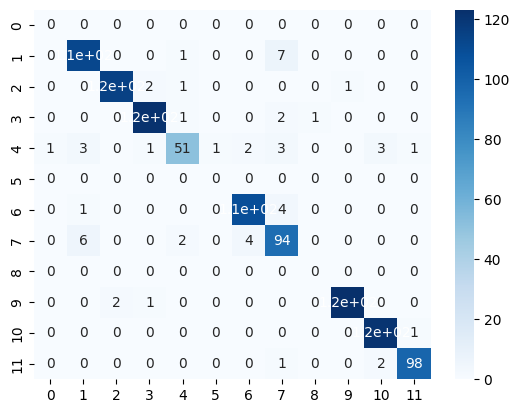

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(label, answer)
#print(cm)

sns.heatmap(cm, annot=True, cmap='Blues')

Notice: ToshiStats Co., Ltd. and I do not accept any responsibility or liability for loss or damage occasioned to any person or property through using materials, instructions, methods, algorithms or ideas contained herein, or acting or refraining from acting as a result of such use. ToshiStats Co., Ltd. and I expressly disclaim all implied warranties, including merchantability or fitness for any particular purpose. There will be no duty on ToshiStats Co., Ltd. and me to correct any errors or defects in the codes and the software.